Steps:
1. Take the full signal and randomly pick N trials
2. Calculate Pearson trial-average
3. Calculate STTC trial-average
4. Calculate STTC on concatenated data
5. Compare 2,3,4, values calculated on full signal, and ground truth

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 

import numpy as np
from random import randrange
# IP import warnings because of "module 'numpy' has no attribute 'warnings'"
import warnings
np.warnings = warnings
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score

# import from scripts
import os
os.chdir(os.path.expanduser("D:\\intr_timescales\\isttc\\scripts"))
from calculate_acf import acf_sttc, sttc_zero_padded, acf_pearsonr_trial_avg, acf_sttc_trial_avg

### Load the data

In [2]:
spike_times = np.load('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\spike_times.npy')
ou_spiketrain_binned = np.load('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\ou_spiketrain_binned.npy')

In [3]:
num_lags = 20
bin_size = 50
sttc_dt = 49
signal_len = 100000

In [4]:
def func_exp_abc_like(x, a, tau):
    return a * np.exp(-x/tau) 

def func_single_exp_monkey_like(x, a, b, c):
    #return a * np.exp(-b * x) + c
    return a * (np.exp(-b * x) + c) # as in the paper

### Calculate acf and sttc for the full signal

In [5]:
t_axes = np.linspace(0,num_lags,num_lags+1).astype(int)
print(t_axes)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [6]:
# Using acf func
spike_train_binned_acf = acf(ou_spiketrain_binned[0], nlags=num_lags)
print('spike_train_binned_acf shape {}, \nspike_train_binned_acf: {}'.format(spike_train_binned_acf.shape, spike_train_binned_acf))

# Using isttc
spike_train_acf = acf_sttc(spike_times, num_lags, lag_shift_=bin_size, sttc_dt_=sttc_dt, signal_length_=signal_len, verbose_=False)
print('spike_train_acf shape {}, \nspike_train_acf: {}'.format(len(spike_train_acf), spike_train_acf))

# calculate tau
spike_train_binned_popt, _ = curve_fit(func_single_exp_monkey_like, t_axes, spike_train_binned_acf, maxfev=5000)
spike_train_binned_tau_ms = (1/spike_train_binned_popt[1]) * bin_size
print('spike_train_binned_popt: {}, spike_train_binned_tau_ms: {}'.format(spike_train_binned_popt, spike_train_binned_tau_ms))

spike_train_popt, _ = curve_fit(func_single_exp_monkey_like, t_axes, spike_train_acf, maxfev=5000)
spike_train_tau_ms = (1/spike_train_popt[1]) * bin_size
print('spike_train_popt: {}, spike_train_tau_ms: {}'.format(spike_train_popt, spike_train_tau_ms))

spike_train_binned_acf shape (21,), 
spike_train_binned_acf: [ 1.          0.49215131  0.2821505   0.1616106   0.08844024  0.07648782
  0.02344463 -0.00867316 -0.01960204 -0.04462376 -0.03282076 -0.03199797
 -0.04016174 -0.00992729 -0.01154496 -0.00658597  0.01306548  0.04077162
  0.06785523  0.04134784  0.0492438 ]
428750
68591
t_stop_ - t_start_: 100000, time_prop: 0.68591
428750
68591
t_stop_ - t_start_: 100000, time_prop: 0.68591
STTC : 1.0
428750
68591
t_stop_ - t_start_: 99950, time_prop: 0.6862531265632816
428750
68591
t_stop_ - t_start_: 99950, time_prop: 0.6861330665332667
428750
68591
t_stop_ - t_start_: 99900, time_prop: 0.6865965965965966
428652
68548
t_stop_ - t_start_: 99900, time_prop: 0.6859759759759759
428750
68591
t_stop_ - t_start_: 99850, time_prop: 0.6869404106159239
428554
68489
t_stop_ - t_start_: 99850, time_prop: 0.6858187280921382
428750
68591
t_stop_ - t_start_: 99800, time_prop: 0.6872845691382765
428358
68448
t_stop_ - t_start_: 99800, time_prop: 0.68566132

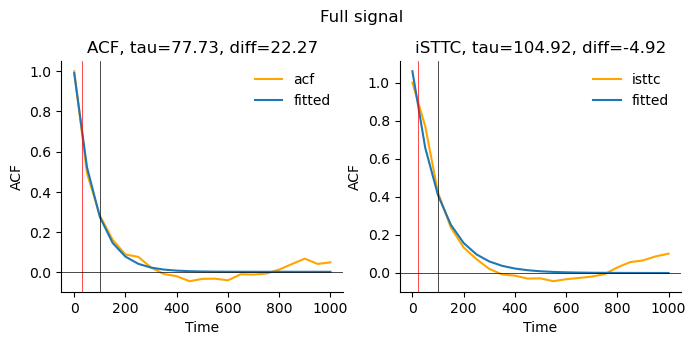

In [7]:
fig, axes = plt.subplots(1,2, figsize=(8,3))

axes[0].plot(t_axes, spike_train_binned_acf, c='orange', label='acf')
axes[0].plot(t_axes, func_single_exp_monkey_like(t_axes, spike_train_binned_popt[0], spike_train_binned_popt[1], spike_train_binned_popt[2]), 
             label='fitted')
axes[0].axvline(x=spike_train_binned_popt[1], lw=0.5, color='red')
axes[0].set_title('ACF, tau={}, diff={}'.format(np.round(spike_train_binned_tau_ms, 2), np.round(100-spike_train_binned_tau_ms, 2)))
axes[0].set_xticks(np.linspace(0,20,6))
axes[0].set_xticklabels(np.linspace(0,1000,6).astype(int))

axes[1].plot(t_axes, spike_train_acf, c='orange', label='isttc')
axes[1].plot(t_axes, func_single_exp_monkey_like(t_axes, spike_train_popt[0], spike_train_popt[1], spike_train_popt[2]), label='fitted')
axes[1].axvline(x=spike_train_popt[1], lw=0.5, color='red')
axes[1].set_title('iSTTC, tau={}, diff={}'.format(np.round(spike_train_tau_ms, 2), np.round(100-spike_train_tau_ms, 2)))
axes[1].set_xticks(np.linspace(0,20,6))
axes[1].set_xticklabels(np.linspace(0,1000,6).astype(int))

fig.suptitle('Full signal', y=1.05)

for ax in axes.flat:
    ax.legend(frameon=False)
    ax.axvline(x=2, lw=0.5, color='k')
    ax.axhline(y=0, lw=0.5, color='k')
    ax.set_xlabel('Time')
    ax.set_ylabel('ACF')

sns.despine()

#fig.savefig('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\figs\\' + 'full_signal.png' , bbox_inches='tight')

### Make trials

In [70]:
n_trials = 100
trial_len = num_lags * bin_size

trials_start = [randrange(0, signal_len-trial_len+1) for i in range(n_trials)]
trials_end = [trial_start + trial_len for trial_start in trials_start]
print('N trials {}, trail len {}, n trial starts {}, \ntrial starts {}, \ntrial starts {}'.format(n_trials, trial_len, 
                                                                                                  len(trials_start), 
                                                                                                  trials_start, trials_end))

trial_intervals = np.vstack((trials_start, trials_end)).T
trial_intervals

N trials 100, trail len 1000, n trial starts 100, 
trial starts [94251, 97038, 59756, 30345, 87456, 57786, 39775, 51479, 81669, 14445, 21860, 26958, 63366, 71004, 85218, 35033, 94899, 97437, 62557, 28668, 63339, 41375, 36174, 49940, 70507, 69295, 4702, 88395, 90098, 69782, 72353, 10351, 54106, 22437, 30302, 89178, 77976, 52661, 89833, 52204, 6736, 22837, 2128, 7712, 45412, 31627, 96134, 10046, 38879, 56912, 97504, 11871, 83291, 5006, 88576, 5683, 3958, 27243, 61643, 54662, 4767, 79322, 17794, 18028, 46175, 33241, 90989, 60467, 45710, 3077, 40013, 43510, 81296, 40804, 82652, 83411, 35631, 79835, 46675, 71041, 98210, 68229, 5628, 46086, 87985, 38874, 95288, 36693, 96555, 44850, 47803, 41474, 7531, 95514, 87034, 51572, 44189, 17480, 79986, 25444], 
trial starts [95251, 98038, 60756, 31345, 88456, 58786, 40775, 52479, 82669, 15445, 22860, 27958, 64366, 72004, 86218, 36033, 95899, 98437, 63557, 29668, 64339, 42375, 37174, 50940, 71507, 70295, 5702, 89395, 91098, 70782, 73353, 11351, 55106, 

array([[94251, 95251],
       [97038, 98038],
       [59756, 60756],
       [30345, 31345],
       [87456, 88456],
       [57786, 58786],
       [39775, 40775],
       [51479, 52479],
       [81669, 82669],
       [14445, 15445],
       [21860, 22860],
       [26958, 27958],
       [63366, 64366],
       [71004, 72004],
       [85218, 86218],
       [35033, 36033],
       [94899, 95899],
       [97437, 98437],
       [62557, 63557],
       [28668, 29668],
       [63339, 64339],
       [41375, 42375],
       [36174, 37174],
       [49940, 50940],
       [70507, 71507],
       [69295, 70295],
       [ 4702,  5702],
       [88395, 89395],
       [90098, 91098],
       [69782, 70782],
       [72353, 73353],
       [10351, 11351],
       [54106, 55106],
       [22437, 23437],
       [30302, 31302],
       [89178, 90178],
       [77976, 78976],
       [52661, 53661],
       [89833, 90833],
       [52204, 53204],
       [ 6736,  7736],
       [22837, 23837],
       [ 2128,  3128],
       [ 77

In [71]:
spikes_trials = []
for i in range(n_trials):
    spikes_trial = spike_times[np.logical_and(spike_times >= trial_intervals[i,0], spike_times < trial_intervals[i,1])]
    spikes_trials.append(spikes_trial)
spikes_trials

[array([94253, 94259, 94301, 94308, 94312, 94390, 94407, 94411, 94414,
        94415, 94417, 94418, 94422, 94428, 94429, 94432, 94437, 94444,
        94446, 94466, 94659, 94688, 94693, 94700, 94722, 94724, 94728,
        94735, 94740, 94756, 94866, 94982, 94985, 94992, 94998, 95007,
        95084, 95096, 95098, 95203, 95211, 95226, 95234], dtype=int64),
 array([97345, 97369, 97377, 97389, 97392, 97432, 97488, 97493, 97510,
        97517, 97519, 97526, 97531, 97551, 97581, 97594, 97597, 97671,
        97784, 97814, 97820, 97829, 97871, 97874, 97876, 97903, 97915,
        97926, 97927, 97944, 97945, 97959, 97962, 97965, 97967, 97973,
        97976, 97977, 97981, 97993], dtype=int64),
 array([59882, 59893, 60384, 60385, 60387, 60390, 60391, 60393, 60396,
        60455], dtype=int64),
 array([30345, 30355, 30356, 30358, 30368, 30373, 30377, 30386, 30390,
        30427, 30442, 30452, 30457, 30463, 30470, 30505, 30508, 30515,
        31305], dtype=int64),
 array([87456, 87466, 87596, 87618, 

In [72]:
# realign all trails to start with 0
spikes_trials_realigned_l = []
for idx, trial in enumerate(spikes_trials):
    spikes_trial_realigned = trial - trial_intervals[idx,0] 
    spikes_trials_realigned_l.append(spikes_trial_realigned)
spikes_trials_realigned_l

[array([  2,   8,  50,  57,  61, 139, 156, 160, 163, 164, 166, 167, 171,
        177, 178, 181, 186, 193, 195, 215, 408, 437, 442, 449, 471, 473,
        477, 484, 489, 505, 615, 731, 734, 741, 747, 756, 833, 845, 847,
        952, 960, 975, 983], dtype=int64),
 array([307, 331, 339, 351, 354, 394, 450, 455, 472, 479, 481, 488, 493,
        513, 543, 556, 559, 633, 746, 776, 782, 791, 833, 836, 838, 865,
        877, 888, 889, 906, 907, 921, 924, 927, 929, 935, 938, 939, 943,
        955], dtype=int64),
 array([126, 137, 628, 629, 631, 634, 635, 637, 640, 699], dtype=int64),
 array([  0,  10,  11,  13,  23,  28,  32,  41,  45,  82,  97, 107, 112,
        118, 125, 160, 163, 170, 960], dtype=int64),
 array([  0,  10, 140, 162, 165, 166, 167, 172, 184, 185, 186, 191, 228,
        240, 246, 251, 265, 270, 287, 331, 337, 340, 346, 366, 367, 368,
        373, 393, 401, 402, 403, 421, 423, 425, 429, 435, 440, 565, 601],
       dtype=int64),
 array([  4,   5,  19,  20,  24,  41,  44,  49,  50

In [73]:
# bin
binned_spikes_trials_l = []

n_bin_edges =  int(trial_len/bin_size)
bins_ = np.linspace(0, bin_size * n_bin_edges, n_bin_edges + 1).astype(int)
for trial in spikes_trials_realigned_l:
    binned_spike_train, _ = np.histogram(trial, bins_)
    binned_spikes_trials_l.append(binned_spike_train)
binned_spikes_trials_l

[array([ 2,  3,  1, 13,  1,  0,  0,  0,  4,  5,  1,  0,  1,  0,  4,  1,  3,
         0,  0,  4], dtype=int64),
 array([ 0,  0,  0,  0,  0,  0,  3,  3,  0,  7,  2,  2,  1,  0,  1,  3,  3,
         4, 10,  1], dtype=int64),
 array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 1, 0, 0, 0, 0, 0, 0],
       dtype=int64),
 array([9, 2, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       dtype=int64),
 array([2, 0, 1, 9, 3, 4, 4, 5, 9, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       dtype=int64),
 array([ 8, 10,  1,  2,  2,  0,  0,  0,  3,  0,  0,  0,  0,  0,  1,  5,  2,
         8,  2,  5], dtype=int64),
 array([9, 6, 1, 0, 1, 4, 3, 3, 0, 0, 0, 0, 0, 4, 0, 0, 2, 1, 8, 1],
       dtype=int64),
 array([1, 1, 6, 3, 5, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2],
       dtype=int64),
 array([5, 7, 7, 8, 2, 2, 0, 0, 2, 3, 4, 2, 2, 2, 1, 0, 1, 1, 0, 0],
       dtype=int64),
 array([2, 2, 1, 0, 0, 0, 2, 2, 1, 5, 1, 0, 3, 1, 0, 1, 0, 0, 0, 0],
       dtype=int64),
 array([ 3,  2,  0,  5,  3,  6,  1,  

In [74]:
binned_spikes_trials_2d = np.asarray(binned_spikes_trials_l)
binned_spikes_trials_2d

array([[ 2,  3,  1, ...,  0,  0,  4],
       [ 0,  0,  0, ...,  4, 10,  1],
       [ 0,  0,  2, ...,  0,  0,  0],
       ...,
       [ 3, 11,  2, ...,  3,  1,  1],
       [ 0,  0,  2, ...,  0,  1,  1],
       [ 1,  3,  3, ...,  0,  0,  0]], dtype=int64)

### Calculate Pearson trial-average and STTC trial-average

In [75]:
acf_matrix_trail_avg, acf_average_trial_avg = acf_pearsonr_trial_avg(binned_spikes_trials_2d, n_lags_=num_lags)
spike_train_trial_avg_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,19,20), acf_average_trial_avg, maxfev=5000)
spike_train_trial_avg_tau_ms = (1/spike_train_trial_avg_popt[1]) * bin_size
print(spike_train_trial_avg_tau_ms)

n_bins to use 20
78.72380860037536


<Axes: >

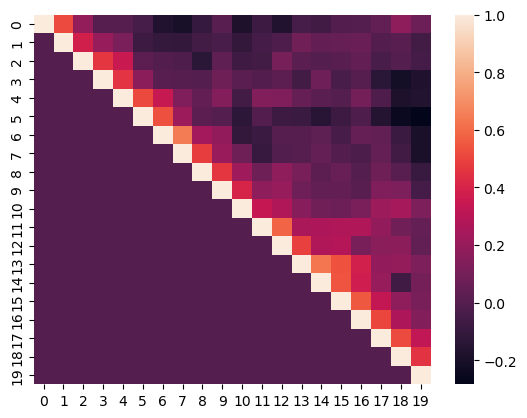

In [76]:
sns.heatmap(acf_matrix_trail_avg)

In [77]:
#acf_sttc_trial_avg(spike_train_l_, lag_shift_=50, zero_padding_len_=150, fs_=1000, sttc_dt_=25, verbose_=True)

sttc_matrix_trail_avg, sttc_average_trial_avg = acf_sttc_trial_avg(spikes_trials_realigned_l, 
                                                                   lag_shift_=bin_size, 
                                                                   zero_padding_len_=120, 
                                                                   fs_=1000, 
                                                                   sttc_dt_=sttc_dt, 
                                                                   verbose_=False)
spike_train_trial_avg_sttc_popt, _ = curve_fit(func_single_exp_monkey_like, np.linspace(0,19,20), sttc_average_trial_avg, maxfev=5000)
spike_train_trial_avg_sttc_tau_ms = (1/spike_train_trial_avg_sttc_popt[1]) * bin_size
print(spike_train_trial_avg_sttc_tau_ms)

21462
6633
t_stop_ - t_start_: 11930, time_prop: 0.5487007544006706
22344
6645
t_stop_ - t_start_: 11930, time_prop: 0.5500419111483654
21462
6633
t_stop_ - t_start_: 11930, time_prop: 0.5487007544006706
23618
7587
t_stop_ - t_start_: 11930, time_prop: 0.6334450963956413
21462
6633
t_stop_ - t_start_: 11930, time_prop: 0.5487007544006706
19502
6181
t_stop_ - t_start_: 11930, time_prop: 0.5141659681475272
21462
6633
t_stop_ - t_start_: 11930, time_prop: 0.5487007544006706
18032
5619
t_stop_ - t_start_: 11930, time_prop: 0.46814752724224645
21462
6633
t_stop_ - t_start_: 11930, time_prop: 0.5487007544006706
19306
5962
t_stop_ - t_start_: 11930, time_prop: 0.4997485331098072
21462
6633
t_stop_ - t_start_: 11930, time_prop: 0.5487007544006706
22246
6207
t_stop_ - t_start_: 11930, time_prop: 0.5202849958088852
21462
6633
t_stop_ - t_start_: 11930, time_prop: 0.5487007544006706
18326
5983
t_stop_ - t_start_: 11930, time_prop: 0.5015088013411567
21462
6633
t_stop_ - t_start_: 11930, time_prop

<Axes: >

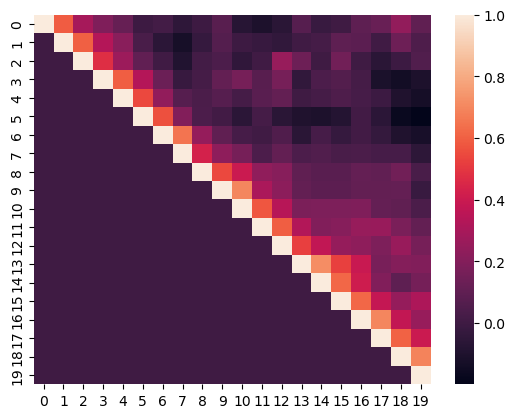

In [78]:
sns.heatmap(sttc_matrix_trail_avg)

In [79]:
sttc_average_trial_avg

array([ 1.        ,  0.59535894,  0.3320781 ,  0.18675246,  0.11087543,
        0.0766165 ,  0.08615344,  0.05990745,  0.04932851,  0.03676425,
        0.02201104,  0.01268193, -0.02401518, -0.00571123, -0.05498385,
       -0.04999243, -0.00421395,  0.10518201,  0.14169383,  0.099776  ])

### Calculate iSTTC on concatenated trials 

In [104]:
zero_padding_len = 2000 # trial len * 2

spike_train_concat = spikes_trials_realigned_l[0]
for idx, trial in enumerate(spikes_trials_realigned_l[1:]):
    spike_train_concat = np.hstack((spike_train_concat, trial+(idx+1)*zero_padding_len))
signal_len_concat = len(spikes_trials_realigned_l)*1000 + (len(spikes_trials_realigned_l)-1)*(zero_padding_len-1000)
print(signal_len_concat)

199000


In [103]:
spike_train_concat[-100:]

array([194595, 194598, 194612, 194613, 194623, 194634, 194639, 194642,
       194643, 194656, 194657, 194660, 194667, 194672, 194673, 194675,
       194684, 194690, 194694, 194700, 194702, 194706, 194718, 194721,
       194727, 194749, 194755, 194761, 194770, 194774, 194783, 194803,
       194834, 194840, 194843, 194852, 194872, 194882, 194901, 194982,
       196115, 196127, 196163, 196175, 196269, 196271, 196276, 196298,
       196299, 196305, 196312, 196316, 196324, 196512, 196517, 196518,
       196586, 196603, 196606, 196609, 196626, 196629, 196634, 196637,
       196645, 196655, 196656, 196668, 196677, 196688, 196692, 196693,
       196694, 196698, 196704, 196720, 196726, 196729, 196733, 196750,
       196751, 196762, 196763, 196770, 196772, 196784, 196797, 196801,
       196829, 196938, 196999, 198041, 198082, 198084, 198092, 198115,
       198120, 198121, 198155, 198471], dtype=int64)

In [18]:
# time_abs = 2 * len(spike_train_concat) * sttc_dt  # maximum possible time
# print(time_abs)

# diff = np.diff(spike_train_concat)
# idx = np.where(diff < (2 * sttc_dt))[0]
# idx_len = len(idx)
# time_abs = time_abs - 2 * idx_len * sttc_dt + diff[idx].sum()
# print(time_abs)

# time_prop = (time_abs / (t_stop_ - t_start_ - zero_padding_len_)) 

In [106]:
zero_padding_total_len = (len(spikes_trials_realigned_l)-1)*(zero_padding_len-1000)
print(zero_padding_total_len)

99000


In [107]:
spike_train_acf_concat = acf_sttc(spike_train_concat, num_lags, lag_shift_=bin_size, sttc_dt_=sttc_dt, signal_length_=signal_len_concat, 
                                  zero_padding_len_=None, verbose_=False)
print('spike_train_acf shape {}, \nspike_train_acf: {}'.format(len(spike_train_acf_concat), spike_train_acf_concat))

spike_train_concat_popt, _ = curve_fit(func_single_exp_monkey_like, t_axes, spike_train_acf_concat, maxfev=5000)
spike_train_concat_tau_ms = (1/spike_train_concat_popt[1]) * bin_size
print('spike_train_concat_popt: {}, spike_train_concat_tau_ms: {}'.format(spike_train_concat_popt, spike_train_concat_tau_ms))

411110
71093
t_stop_ - t_start_: 199000, time_prop: 0.3570150753768844
411110
71093
t_stop_ - t_start_: 199000, time_prop: 0.3570150753768844
STTC : 1.0
410914
71045
t_stop_ - t_start_: 198950, time_prop: 0.3568534807740638
411110
71093
t_stop_ - t_start_: 198950, time_prop: 0.35710480020105556
410620
70956
t_stop_ - t_start_: 198900, time_prop: 0.35669180492709907
411110
71093
t_stop_ - t_start_: 198900, time_prop: 0.3571945701357466
410522
70939
t_stop_ - t_start_: 198850, time_prop: 0.35653004777470454
411110
71093
t_stop_ - t_start_: 198850, time_prop: 0.3572843852149862
409248
70880
t_stop_ - t_start_: 198800, time_prop: 0.3563682092555332
411110
71093
t_stop_ - t_start_: 198800, time_prop: 0.357374245472837
409150
70782
t_stop_ - t_start_: 198750, time_prop: 0.3561358490566038
411110
71093
t_stop_ - t_start_: 198750, time_prop: 0.35746415094339623
409150
70782
t_stop_ - t_start_: 198700, time_prop: 0.3562254655259185
411110
71093
t_stop_ - t_start_: 198700, time_prop: 0.357554101

In [108]:
spike_train_acf_concat = acf_sttc(spike_train_concat, num_lags-1, lag_shift_=bin_size, sttc_dt_=sttc_dt, signal_length_=signal_len_concat, 
                                  zero_padding_len_=zero_padding_total_len, verbose_=False)
print('spike_train_acf shape {}, \nspike_train_acf: {}'.format(len(spike_train_acf_concat), spike_train_acf_concat))

spike_train_concat_popt, _ = curve_fit(func_single_exp_monkey_like, t_axes[:-1], spike_train_acf_concat, maxfev=5000)
spike_train_concat_tau_ms = (1/spike_train_concat_popt[1]) * bin_size
print('spike_train_concat_popt: {}, spike_train_concat_tau_ms: {}'.format(spike_train_concat_popt, spike_train_concat_tau_ms))

411110
71093
t_stop_ - t_start_ - zero_padding_len_: 100000, time_prop: 0.71046
0.71046
411110
71093
t_stop_ - t_start_ - zero_padding_len_: 100000, time_prop: 0.71046
0.71046
410914
71045
t_stop_ - t_start_ - zero_padding_len_: 99950, time_prop: 0.7103151575787894
0.7103151575787894
411110
71093
t_stop_ - t_start_ - zero_padding_len_: 99950, time_prop: 0.7108154077038519
0.7108154077038519
410620
70956
t_stop_ - t_start_ - zero_padding_len_: 99900, time_prop: 0.7101701701701701
0.7101701701701701
411110
71093
t_stop_ - t_start_ - zero_padding_len_: 99900, time_prop: 0.7111711711711711
0.7111711711711711
410522
70939
t_stop_ - t_start_ - zero_padding_len_: 99850, time_prop: 0.7100250375563345
0.7100250375563345
411110
71093
t_stop_ - t_start_ - zero_padding_len_: 99850, time_prop: 0.7115272909364047
0.7115272909364047
409248
70880
t_stop_ - t_start_ - zero_padding_len_: 99800, time_prop: 0.709879759519038
0.709879759519038
411110
71093
t_stop_ - t_start_ - zero_padding_len_: 99800, tim

### Plot all ACFs

In [84]:
def sttc_calculate_t(spiketrain_, n_spikes_, dt_, t_start_, t_stop_, zero_padding_len_=None):
    """
    Calculate the proportion of the total recording time 'tiled' by spikes.
    """
    time_abs = 2 * n_spikes_ * dt_  # maximum possible time
    print(time_abs)

    if n_spikes_ == 1:  # for just one spike in train
        if spiketrain_[0] - t_start_ < dt_:
            time_abs = time_abs - dt_ + spiketrain_[0] - t_start_
        elif spiketrain_[0] + dt_ > t_stop_:
            time_abs = time_abs - dt_ - spiketrain_[0] + t_stop_

    else:  # if more than one spike in train
        diff = np.diff(spiketrain_)
        idx = np.where(diff < (2 * dt_))[0]
        idx_len = len(idx)
        time_abs = time_abs - 2 * idx_len * dt_ + diff[idx].sum()
        print(time_abs)

        # todo this part and the same part above
        if (spiketrain_[0] - t_start_) < dt_:
            time_abs = time_abs + spiketrain_[0] - dt_ - t_start_
        if (t_stop_ - spiketrain_[n_spikes_ - 1]) < dt_:
            time_abs = time_abs - spiketrain_[-1] - dt_ + t_stop_

    if zero_padding_len_ is None:
        time_prop = (time_abs / (t_stop_ - t_start_))  # .item()
        print('t_stop_ - t_start_: {}, time_prop: {}'.format(t_stop_ - t_start_, time_prop))
    else:
        time_prop = (time_abs / (t_stop_ - t_start_ - zero_padding_len_))  # .item()
        print('t_stop_ - t_start_ - zero_padding_len_: {}, time_prop: {}'.format(t_stop_ - t_start_-zero_padding_len_, time_prop))
        print(time_prop)

    return time_abs, time_prop

In [85]:
len(spike_train_concat)

4195

In [109]:
t_ = sttc_calculate_t(spike_train_concat, len(spike_train_concat), sttc_dt, t_start_=0, t_stop_=signal_len_concat, 
                      zero_padding_len_=zero_padding_total_len)
print(t_)

411110
71093
t_stop_ - t_start_ - zero_padding_len_: 100000, time_prop: 0.71046
0.71046
(71046, 0.71046)


In [110]:
zero_padding_len_1 = 1000 # trial len * 2

spike_train_concat_1 = spikes_trials_realigned_l[0]
for idx, trial in enumerate(spikes_trials_realigned_l[1:]):
    spike_train_concat_1 = np.hstack((spike_train_concat_1, trial+(idx+1)*zero_padding_len_1))
signal_len_concat_1 = len(spikes_trials_realigned_l)*1000
print(signal_len_concat_1)

zero_padding_total_len_1 = (len(spikes_trials_realigned_l)-1)*zero_padding_len_1

t_abs_1, t_1_ = sttc_calculate_t(spike_train_concat_1, len(spike_train_concat_1), sttc_dt, t_start_=0, t_stop_=signal_len_concat_1, 
                      zero_padding_len_=None)
print(t_abs_1, t_1_)

100000
411110
68957
t_stop_ - t_start_: 100000, time_prop: 0.6891
68910 0.6891


In [111]:
t_abs_sum = 0
for spike_trial in spikes_trials_realigned_l:
    t_abs_, t_proc_ = sttc_calculate_t(spike_trial, len(spike_trial), sttc_dt, t_start_=0, t_stop_=1000, 
                      zero_padding_len_=None)
    print(t_abs_, t_proc_)
    t_abs_sum = t_abs_sum + t_abs_

4214
947
t_stop_ - t_start_: 1000, time_prop: 0.868
868 0.868
3920
731
t_stop_ - t_start_: 1000, time_prop: 0.727
727 0.727
980
278
t_stop_ - t_start_: 1000, time_prop: 0.278
278 0.278
1862
366
t_stop_ - t_start_: 1000, time_prop: 0.308
308 0.308
3822
640
t_stop_ - t_start_: 1000, time_prop: 0.591
591 0.591
4802
845
t_stop_ - t_start_: 1000, time_prop: 0.754
754 0.754
4214
846
t_stop_ - t_start_: 1000, time_prop: 0.764
764 0.764
2254
674
t_stop_ - t_start_: 1000, time_prop: 0.624
624 0.624
4802
870
t_stop_ - t_start_: 1000, time_prop: 0.842
842 0.842
2058
687
t_stop_ - t_start_: 1000, time_prop: 0.659
659 0.659
4802
792
t_stop_ - t_start_: 1000, time_prop: 0.776
776 0.776
5978
1004
t_stop_ - t_start_: 1000, time_prop: 0.964
964 0.964
3038
479
t_stop_ - t_start_: 1000, time_prop: 0.442
442 0.442
6468
955
t_stop_ - t_start_: 1000, time_prop: 0.907
907 0.907
3920
571
t_stop_ - t_start_: 1000, time_prop: 0.571
571 0.571
3626
620
t_stop_ - t_start_: 1000, time_prop: 0.62
620 0.62
1764
630
t

In [112]:
t_abs_sum

67459

In [113]:
t_abs_sum/(len(spikes_trials_realigned_l) * 1000)

0.67459